<a href="https://colab.research.google.com/github/robinjmf/Audio_Analysis/blob/main/Copy_of_Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# # TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# import os
# import sys
# from tempfile import NamedTemporaryFile
# from urllib.request import urlopen
# from urllib.parse import unquote, urlparse
# from urllib.error import HTTPError
# from zipfile import ZipFile
# import tarfile
# import shutil

# CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'gtzan-dataset-music-genre-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F568973%2F1032238%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240819%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240819T070035Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D163df12b422ca35e1086d6efdcf618e900ecb71a0832bdc8de729ac5d66eb0e73c479629b8d1e95df7584ab32547fce3f76457effdb5f48ce68184d1f2c0411e1717dbe6fc406bcf675b847a1c5e746633e8a6aba27dd38496308030f347ffde09fdb6c8c1bbb4f071c1c1946bcdde74342c80725a07662ce7e715a991a3bb64d02c603f46b869fe461c9cddde96ed99cd9b4de69546901fc7848219139747df56aca9ff492ec5720a6c3b88d2e2183bb586b42138fb8daff56355a21ad60bcbf8fef2f9aae09f08da1f1f2b3f761e548e457e5816819e70d0ac0040eb6f7040f87929783d748aa26a43a08f412e0bb42fb425437dea238510a028611bd38408'

# KAGGLE_INPUT_PATH='/kaggle/input'
# KAGGLE_WORKING_PATH='/kaggle/working'
# KAGGLE_SYMLINK='kaggle'

# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree('/kaggle/input', ignore_errors=True)
# os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
# os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# try:
#   os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
# except FileExistsError:
#   pass
# try:
#   os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
# except FileExistsError:
#   pass

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             if filename.endswith('.zip'):
#               with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#             else:
#               with tarfile.open(tfile.name) as tarfile:
#                 tarfile.extractall(destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue

# print('Data source import complete.')


In [8]:
import kagglehub
import shutil
import os


# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)



# Define the target path in a writable directory on Colab
target_path = '/content/kaggle/input/gtzan-dataset-music-genre-classification'
os.makedirs(target_path, exist_ok=True)

# Move files from the download location to the target path
shutil.move(path, target_path)

print("Dataset successfully moved to:", target_path)

100%|██████████| 1.21G/1.21G [00:14<00:00, 89.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
Dataset successfully moved to: /content/kaggle/input/gtzan-dataset-music-genre-classification


# Music Genre Classification
In this notebook I tried to learn the basic concepts of neural networks and use it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [9]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np

In [10]:

dataset_path = r"../content/kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [11]:
import os
import librosa
import json
import math

SAMPLE_RATE = 22050
SAMPLES_PER_TRACK = SAMPLE_RATE * 30  # Assuming 30 seconds per track

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
              hop_length=512, num_segments=5, selected_genres=None):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)  # ps = per segment
    expected_vects_ps = math.ceil(samples_ps / hop_length)

    # Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # Ensuring not at root
        if dirpath is not dataset_path:
            # Save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]

            # Check if the genre is in the selected genres list (if provided)
            if selected_genres is None or semantic_label in selected_genres:
                data["mapping"].append(semantic_label)
                print(f"Processing: {semantic_label}")

                # Process files for specific genre
                for f in filenames:
                    if f == "jazz.00054.wav":
                        # As librosa only reads files <1Mb
                        continue
                    else:
                        # Load audio file
                        file_path = os.path.join(dirpath, f)
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                        for s in range(num_segments):
                            start_sample = samples_ps * s
                            finish_sample = start_sample + samples_ps

                            mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                        sr=sr,
                                                        n_fft=n_fft,
                                                        n_mfcc=n_mfcc,
                                                        hop_length=hop_length)

                            mfcc = mfcc.T

                            # Store MFCC if it has the expected length
                            if len(mfcc) == expected_vects_ps:
                                data["mfcc"].append(mfcc.tolist())
                                data["labels"].append(i - 1)
                                print(f"{file_path}, segment: {s + 1}")

    # Save the data as a JSON file
    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

# Example usage:
# save_mfcc('dataset_path', 'output.json', selected_genres=['classical', 'rock'])


In [12]:
from IPython.display import clear_output

In [13]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

In [16]:
filepath = r"../content/kaggle/input/gtzan-dataset-music-genre-classification/1/Data/genres_original/blues/blues.0000"

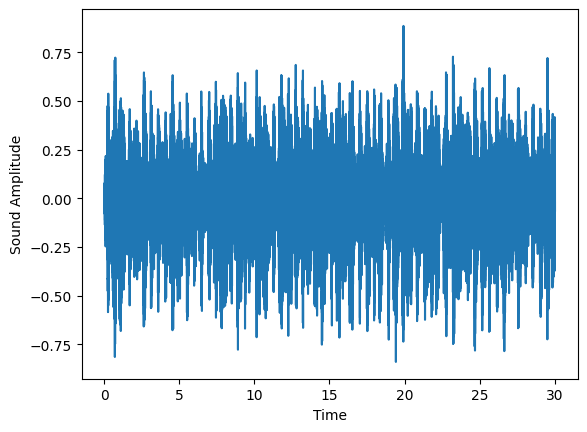

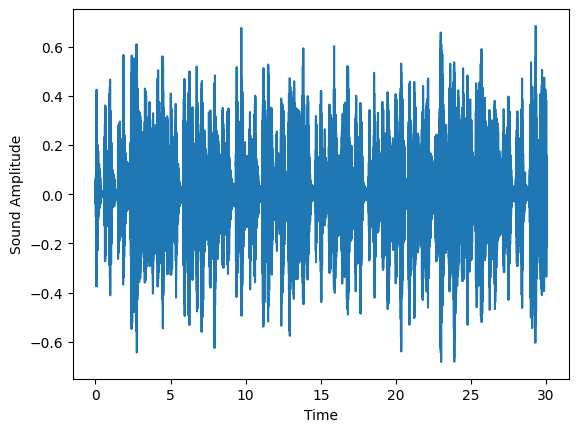

In [17]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. I have also done splitting in the ratio 70:30

The model is Sequential and architecture only has Flatten and the Dense layers available in keras for the basic ANN representation. As it is naive model we can expect it to be overfit. Info on the layers can be found [here](https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/)

In [18]:
import json
import numpy as np

In [19]:
import json
import numpy as np
from keras.utils import to_categorical

# Genre labels mapping
GENRE_LABELS = {
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"
}

def load_data(dataset_path, selected_genres=None):
    with open(dataset_path, "r") as f:
        data = json.load(f)

    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    if selected_genres is not None:
        # Convert selected_genres names to corresponding label indices
        selected_indices = [label for label, genre in GENRE_LABELS.items() if genre in selected_genres]
        print("SELECTED_INDICES", selected_indices)

        # Filter inputs and targets to only include the selected genres
        mask = np.isin(targets, selected_indices)
        inputs = inputs[mask]
        targets = targets[mask]

        # Create a label_map to reflect selected genre indices
        label_map = {old_label: idx for idx, old_label in enumerate(selected_indices)}
        print("LABEL_MAP", label_map)

        # Adjust the targets to reflect the new label indices starting from 0
        targets = np.array([label_map[target] for target in targets])
    else:
        # If no genres are selected, create a default label_map where each genre maps to itself
        label_map = {i: i for i in range(10)}

    # Convert labels to one-hot encoding with size 10
    targets = to_categorical(targets, num_classes=10)

    return inputs, targets, label_map


In [20]:
inputs, targets, label_map = load_data(dataset_path=r"./data.json", selected_genres=['classical', 'rock', 'jazz'])

SELECTED_INDICES [4, 5, 6]
LABEL_MAP {4: 0, 5: 1, 6: 2}


In [21]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(2099, 130, 13) (2099, 10)


In [22]:
# input_train[0].shape

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [24]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1690)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         865,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [26]:
model.compile(optimizer=adam,
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [27]:
hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 30,
                 batch_size = 32)
clear_output()

In [28]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

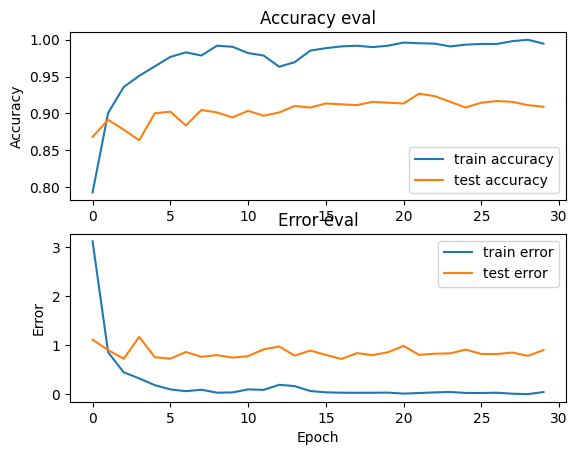

In [29]:
plot_history(hist)

In [30]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9050 - loss: 0.9502 
Test accuracy: 0.9088888764381409


In [31]:
target_test[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
label_map

{4: 0, 5: 1, 6: 2}

In [33]:
inv_label_map = {v: k for k, v in label_map.items()}
inv_label_map

{0: 4, 1: 5, 2: 6}

In [34]:
genre_names = [GENRE_LABELS[inv_label_map[i]] for i in range(len(inv_label_map))]
genre_names[::-1]

['jazz', 'classical', 'rock']

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


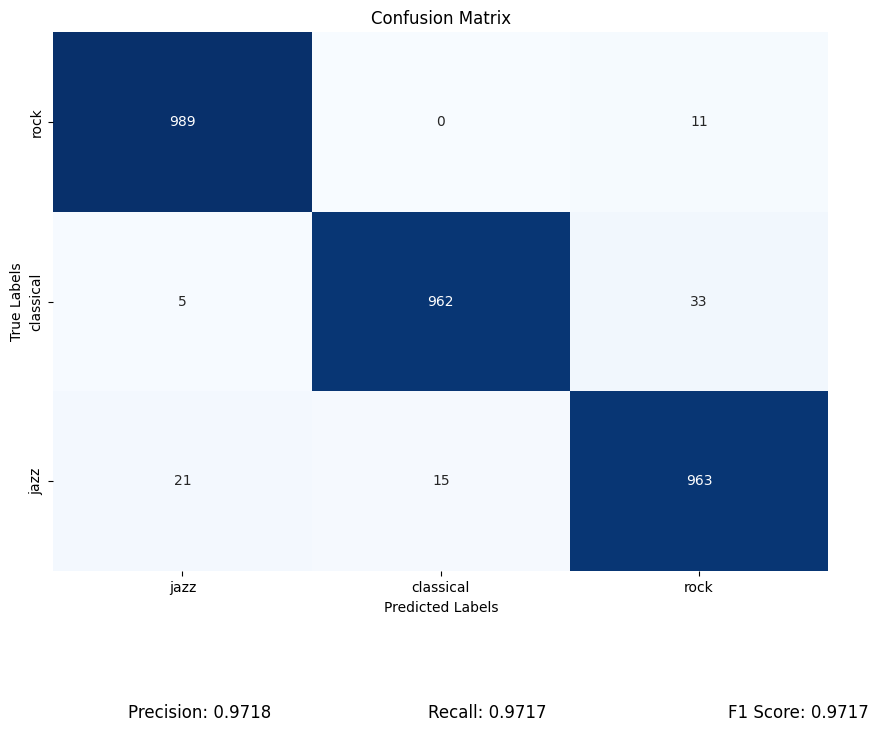

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming 'model' is your trained model
predictions = model.predict(inputs)
predicted_labels = predictions.argmax(axis=1)
true_labels = targets.argmax(axis=1)


# Step 2: Compute metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Reverse the label_map to get the genre names in order
inv_label_map = {v: k for k, v in label_map.items()}
genre_names = [GENRE_LABELS[inv_label_map[i]] for i in range(len(inv_label_map))]

# Plot the confusion matrix with genre names
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=genre_names[::-1],
            yticklabels=genre_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display metrics
plt.figtext(0.2, -0.1, f'Precision: {precision:.4f}', fontsize=12)
plt.figtext(0.5, -0.1, f'Recall: {recall:.4f}', fontsize=12)
plt.figtext(0.8, -0.1, f'F1 Score: {f1:.4f}', fontsize=12)

plt.show()


# Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.
- Making architecture less complicated
- Using augmented data
- Early stopping of training
- Adding dropout layers
- Regularization / Standardization  

I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30%
Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. More info can be found [here](https://medium.com/@robertjohn_15390/regularization-in-tensorflow-using-keras-api-48aba746ae21)

In [36]:
import tensorflow.keras as keras

In [37]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
# model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 1690)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         865,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,015,978 (3.88 MB)

 Trainable params: 1,015,978 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

<Figure size 2000x1500 with 0 Axes>

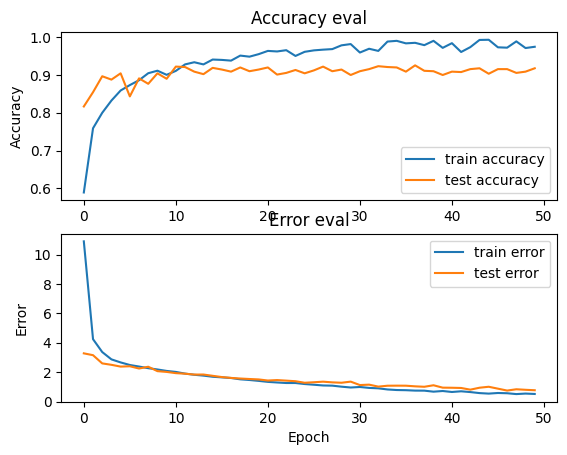

In [39]:
plot_history(hist)

In [40]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9109 - loss: 0.7739 
Test accuracy: 0.9177777767181396


We can see that the overfitting is greatly reduced but still we are not able to get a good accuracy. Now we will try doing it with Convolutional Neural Network (CNN)

# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

In [41]:
def prepare_dataset(test_size, validation_size):
    X, y, _ = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [42]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [43]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [44]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 11, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 6, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 6, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 4, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 2, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 2, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 1, 32)           │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 15, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 1, 16)           │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 1, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,242 (129.85 KB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [45]:
new_optimizer = keras.optimizers.Adam()
model.compile(optimizer=new_optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.2852 - loss: 2.1618 - val_accuracy: 0.3792 - val_loss: 1.6620
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4750 - loss: 1.4242 - val_accuracy: 0.5421 - val_loss: 1.2493
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5398 - loss: 1.2626 - val_accuracy: 0.5935 - val_loss: 1.0983
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5905 - loss: 1.1281 - val_accuracy: 0.5781 - val_loss: 1.1569
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6158 - loss: 1.0530 - val_accuracy: 0.6615 - val_loss: 0.9649
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6584 - loss: 0.9742 - val_accuracy: 0.6509 - val_loss: 0.9811
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6891 - loss: 0.8694 - val_accuracy: 0.6529 - val_loss: 0.9662
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6787 - loss: 0.9001 - val_accuracy: 

<Figure size 2000x1500 with 0 Axes>

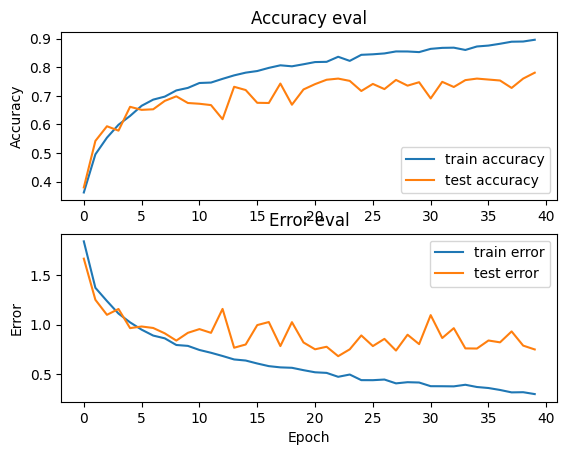

In [46]:
plot_history(hist)

In [47]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7647 - loss: 0.8331
Test accuracy: 0.7693231701850891


In [48]:
def predict_(model, X, y):
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [49]:
X_test.shape

(2497, 130, 13, 1)

In [50]:
predict_(model, X_test, y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Expected index: [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], Predicted index: [1 6 0 ... 3 2 3]


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Expected index: [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], Predicted index: [1 6 0 ... 3 2 3]


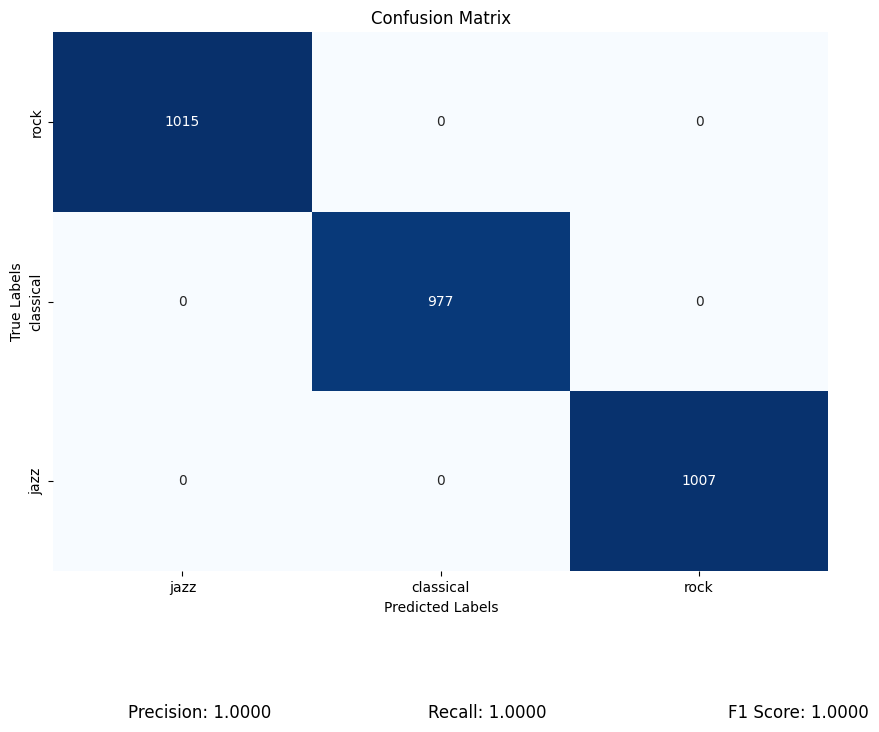

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming 'model' is your trained model
predictions = predict_(model, X_test,y_test)
# predicted_labels = predictions.argmax(axis=1)
# true_labels = targets.argmax(axis=1)


# Step 2: Compute metrics
conf_matrix = confusion_matrix(predicted_labels, predicted_labels)
precision = precision_score(predicted_labels, predicted_labels, average='weighted')
recall = recall_score(predicted_labels, predicted_labels, average='weighted')
f1 = f1_score(predicted_labels, predicted_labels, average='weighted')

# Reverse the label_map to get the genre names in order
inv_label_map = {v: k for k, v in label_map.items()}
genre_names = [GENRE_LABELS[inv_label_map[i]] for i in range(len(inv_label_map))]

# Plot the confusion matrix with genre names
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=genre_names[::-1],
            yticklabels=genre_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display metrics
plt.figtext(0.2, -0.1, f'Precision: {precision:.4f}', fontsize=12)
plt.figtext(0.5, -0.1, f'Recall: {recall:.4f}', fontsize=12)
plt.figtext(0.8, -0.1, f'F1 Score: {f1:.4f}', fontsize=12)

plt.show()
